In [35]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import csv
import helpers
from numpy import linalg as LA
import pandas as pd
from implementations import *
import datetime

### **0. Load the data**

In [36]:
## load train data 
DATA_PATH_TRAIN = 'data/train.csv'
DATA_PATH_TEST = 'data/test.csv'
y_tr, x_tr, ids_tr = helpers.load_csv_data(DATA_PATH_TRAIN, sub_sample = False)
y_te, x_te, ids_te = helpers.load_csv_data(DATA_PATH_TEST, sub_sample = False)

In [37]:
print(x_tr.shape, y_tr.shape)

(250000, 30) (250000,)


In [38]:
## a function to make a figure of scatter-plots
def plot_scatters(X, Y):
    f, ax = plt.subplots(5, 3, figsize = (20, 20), sharey=False, sharex =False)
    n = 0
    for i in range(5):
        for j in range(3):
            ax[i, j].scatter(X[:, n], X[:, 15+n], c = Y, s=0.5)
            ax[i, j].set_title('features ' + str(n) + ' and ' +str(15+n))
            n +=1
        
    f.tight_layout()

### **1. First insights of the Data**

Let's see scatter plots of all features, with colors to see different classes.

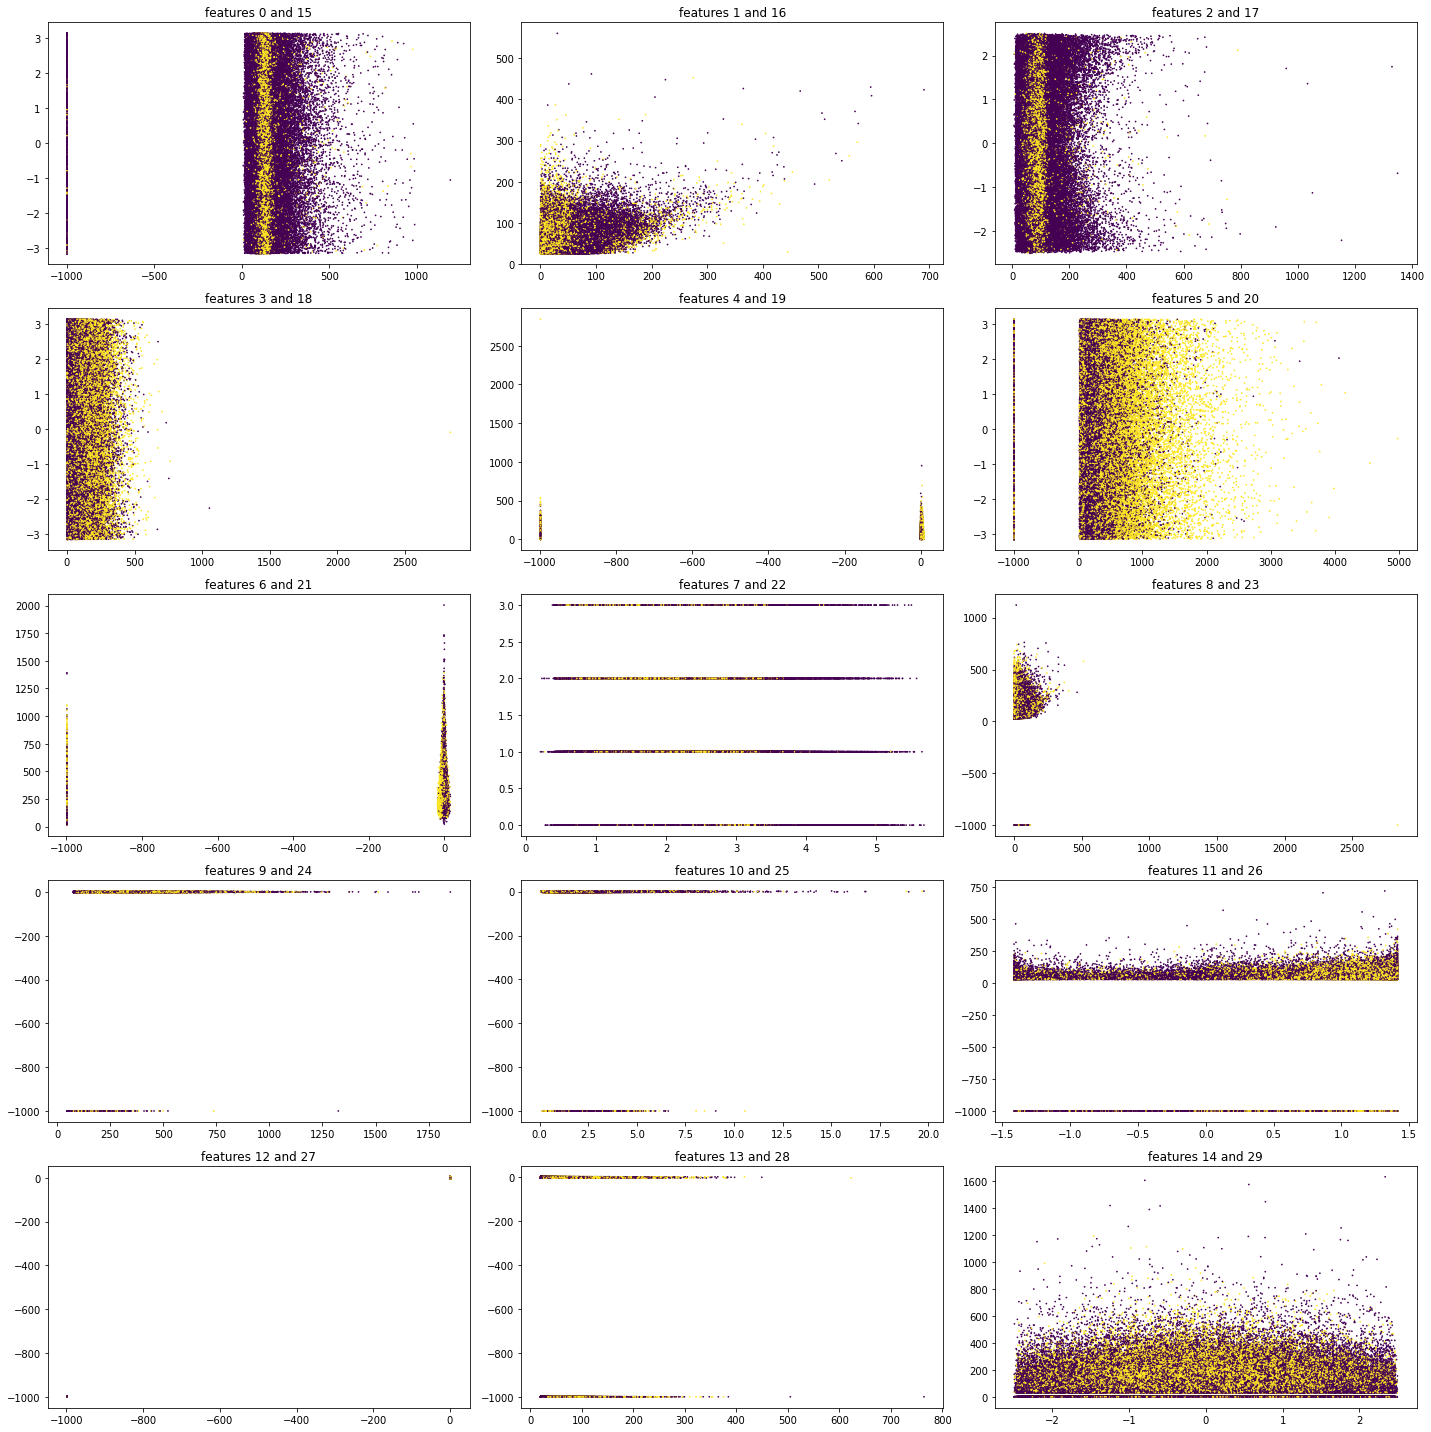

In [39]:

plot_scatters(x_tr, y_tr)

We can make few observations : 
- For some features, we have -999 values, that we will have to deal with.
- Every features are continuous, except for feature 22, that takes values in {0, 1, 2, 3}.
- It is very difficult to see distribution of data for some features, because of the -999 values. Let's have a better look at data, by removing these values. 

We make a scatter plots of all features, after removing all rows with -999 values. clean_subset is a subset of train data, without any -999 values. We will see how we found it further in this notebook


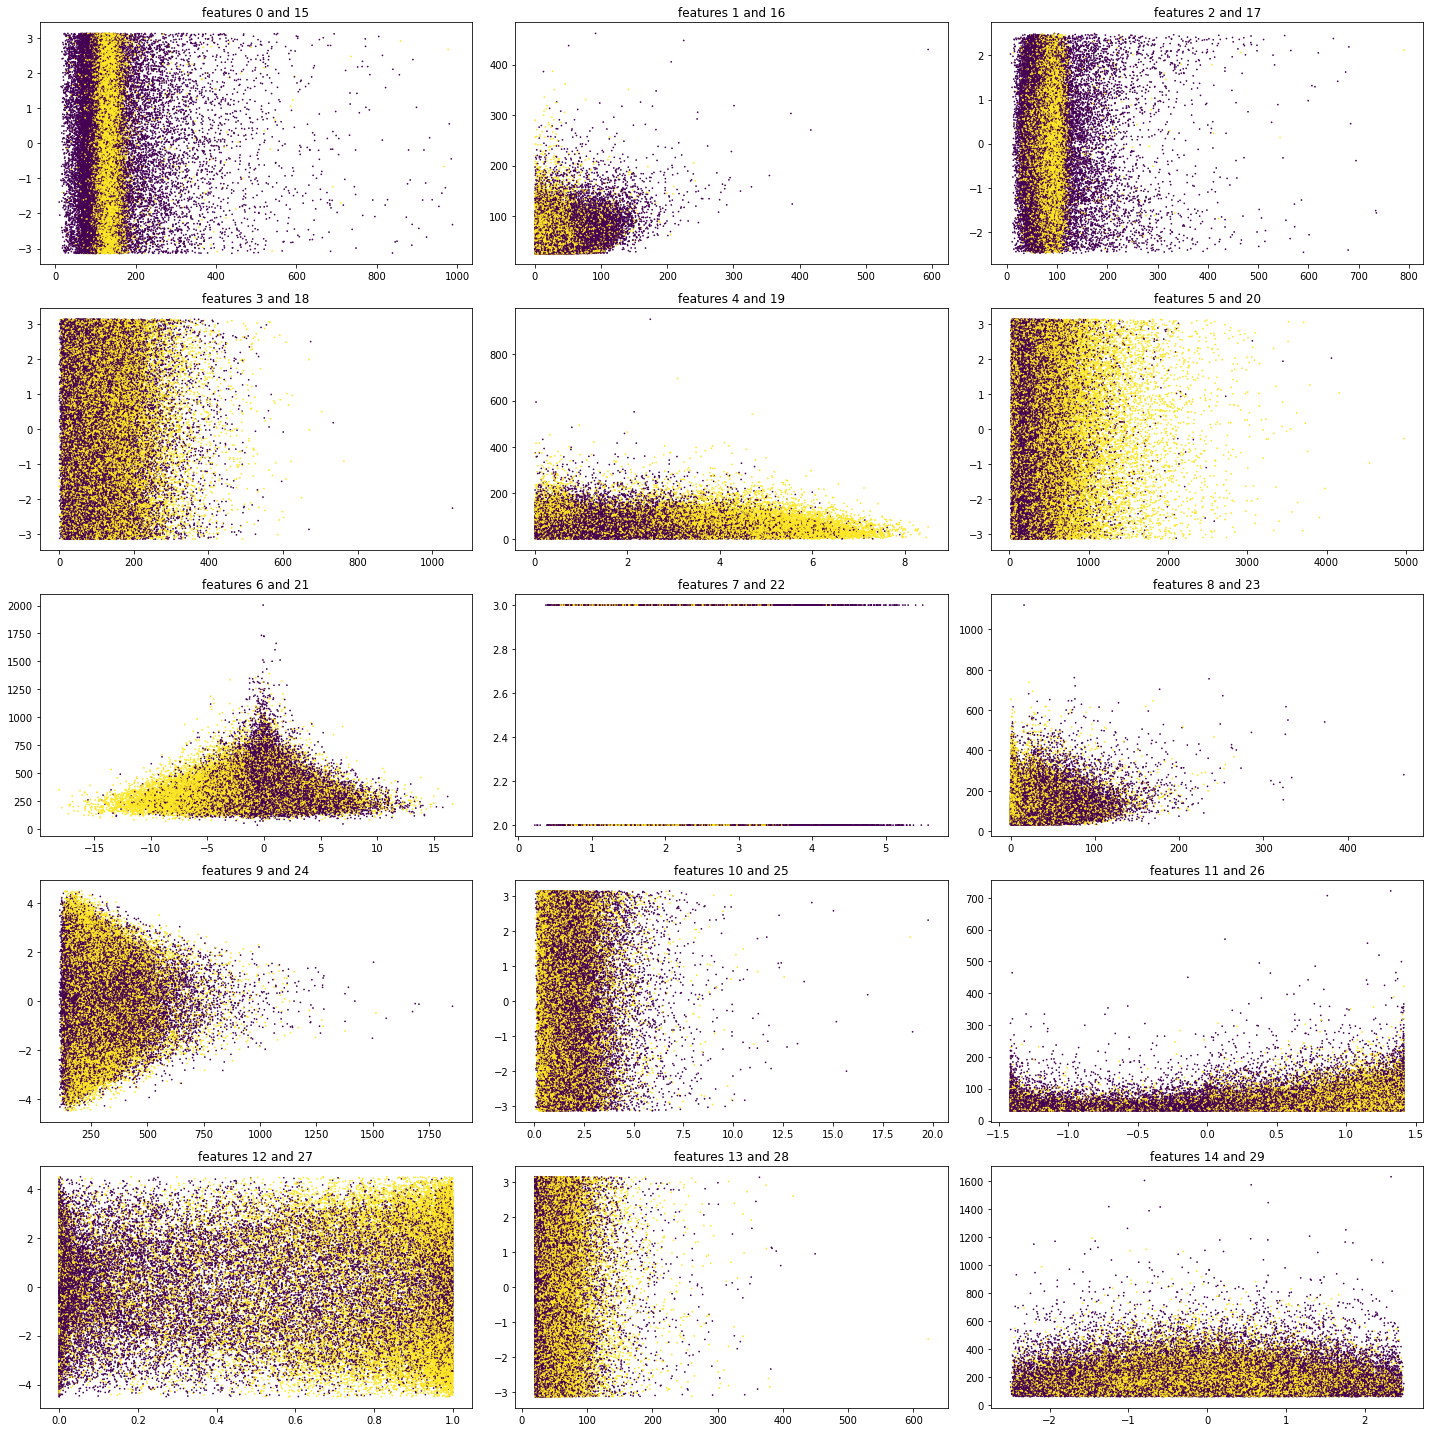

In [40]:
clean_subset = (x_tr[:,0]!=-999.)&(x_tr[:,4]!=-999.)
x_tr_clean = x_tr[clean_subset]
y_tr_clean = y_tr[clean_subset]

plot_scatters(x_tr_clean, y_tr_clean)

Now in this new graph, data is much easier to see. 
We can complete with these observations :
- For feature 22, we can see that there is no observations that took values 0 and 1 anymore.
- It's also a good way to see for wich features data seems the most separable. 

### **2. How to deal with -999 values** 

We know that most observations in this train dataset contains at least one -999 value, and that we have to deal with them. If we don't and let them like that to train and make predictions, we are almost sure that it will ruin them. 

Our first idea was to replace these -999 values by the mean of all the non -999 values, for each feature. This technique gives us satisfying accuracies (as we will see further), but we knew that we could improve that another way. 

Our second idea was : why don't we separate data into several subsets, one with -999 values and another with non -999 values, and then train two classifiers for each case ? We will develop this idea in the next cases.

let's plot scatters of all features, after separating data for feature 0.
we separate data into two subsets first : 
- one for which feature0 =  -999
- one for which feature0 != -999

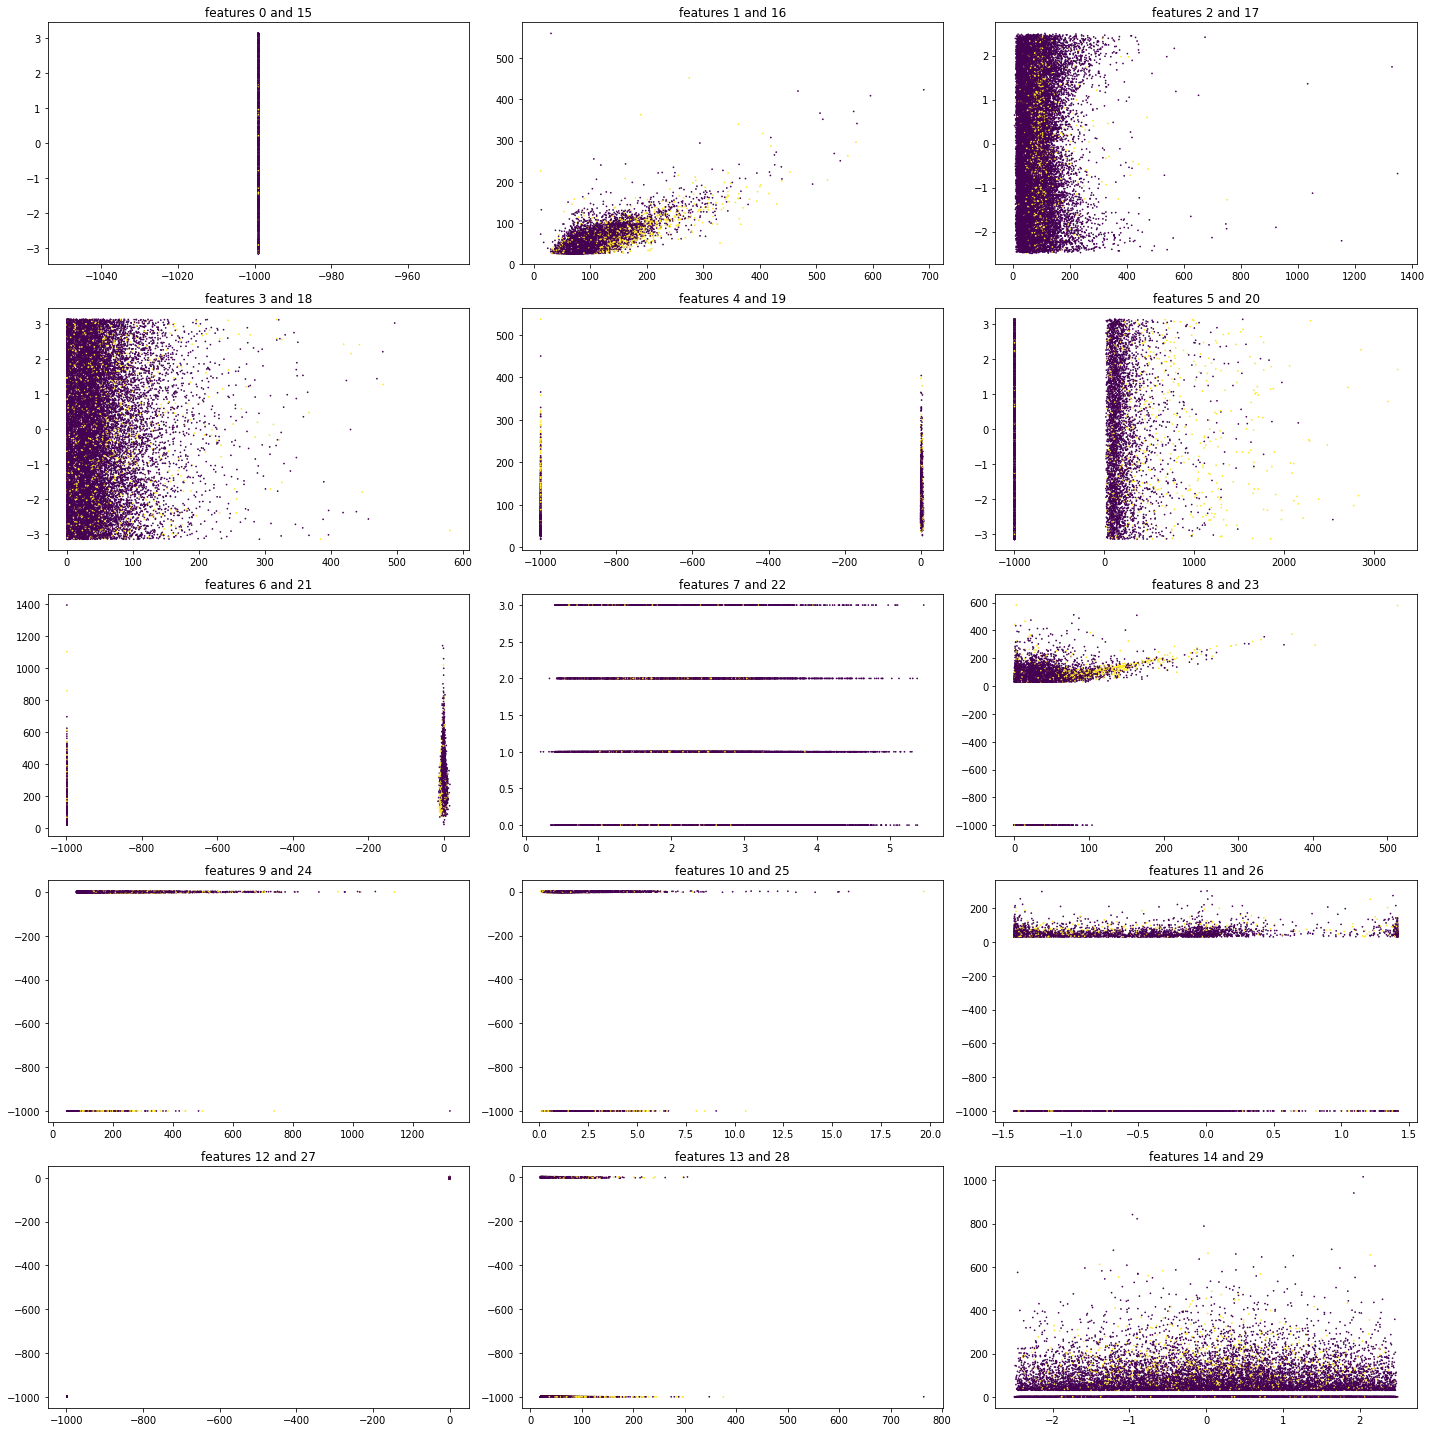

In [41]:
x_tr_999_values= x_tr[x_tr[:,0]==-999.]
y_tr_999_values = y_tr[x_tr[:,0]==-999.]

plot_scatters(x_tr_999_values, y_tr_999_values)

As we can see, there is still -999 values for this subset. Let's look at the part where feature0 is different than -999.

In [42]:
x_tr_non999_values= x_tr[x_tr[:,0]!=-999.]
y_tr_non999_values = y_tr[x_tr[:,0]!=-999.]

plot_scatters(x_tr_non999_values, y_tr_non999_values)

Error in callback <function flush_figures at 0x7fdb80d89c10> (for post_execute):


KeyboardInterrupt: 

As we can see, there is still also some -999 values. we will then have to separate data again. This time we will divide, these already divided subsets, into other subsets : 
- for feature 4 equals or different than  -999
- for feature 23 equals or different than  -999

At the end, we will indeed have 5 independant subsets, all without a feature mixing -999 and non -999 values.

### *Subset 1*

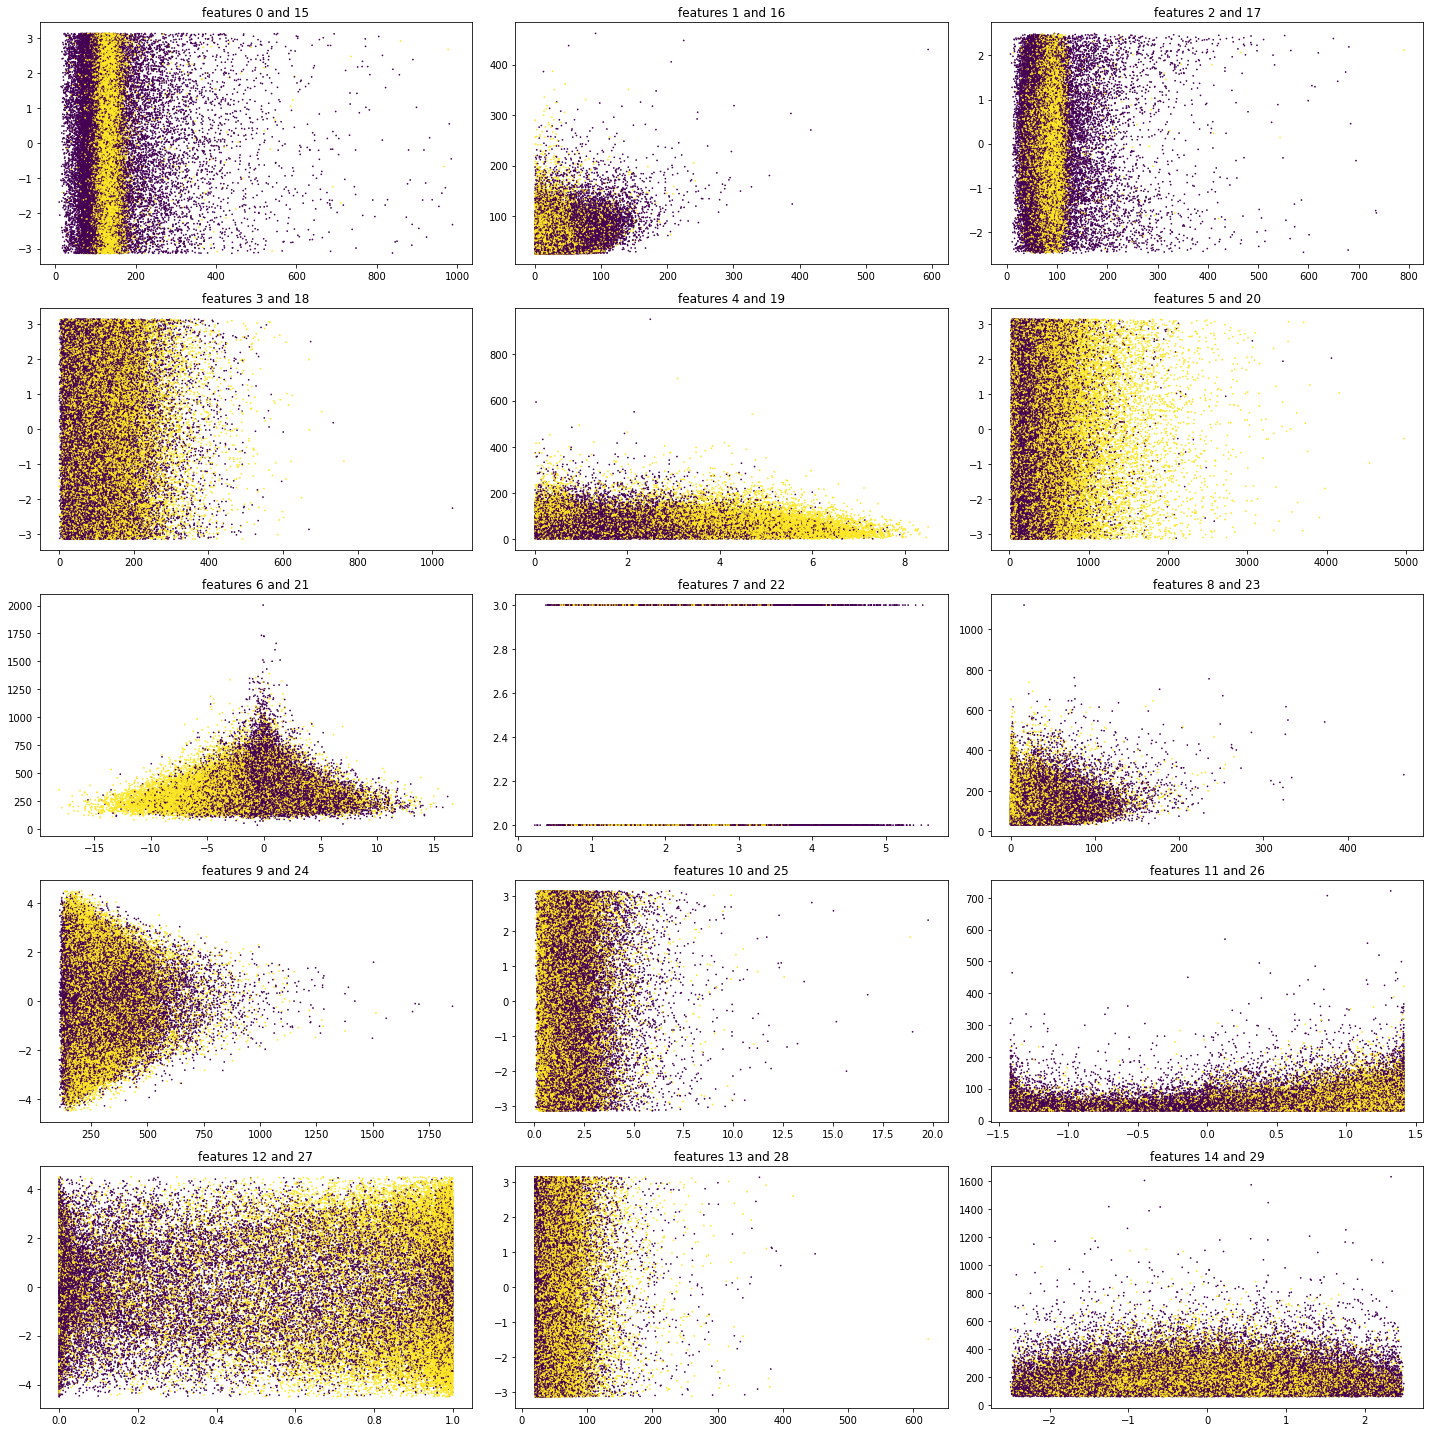

In [ ]:
X_1 = x_tr[(x_tr[:,0]!=-999.)&(x_tr[:,4]!=-999.)]
Y_1 = y_tr[(x_tr[:,0]!=-999.)&(x_tr[:,4]!=-999.)]
    
plot_scatters(X_1, Y_1)

### *Subset2*


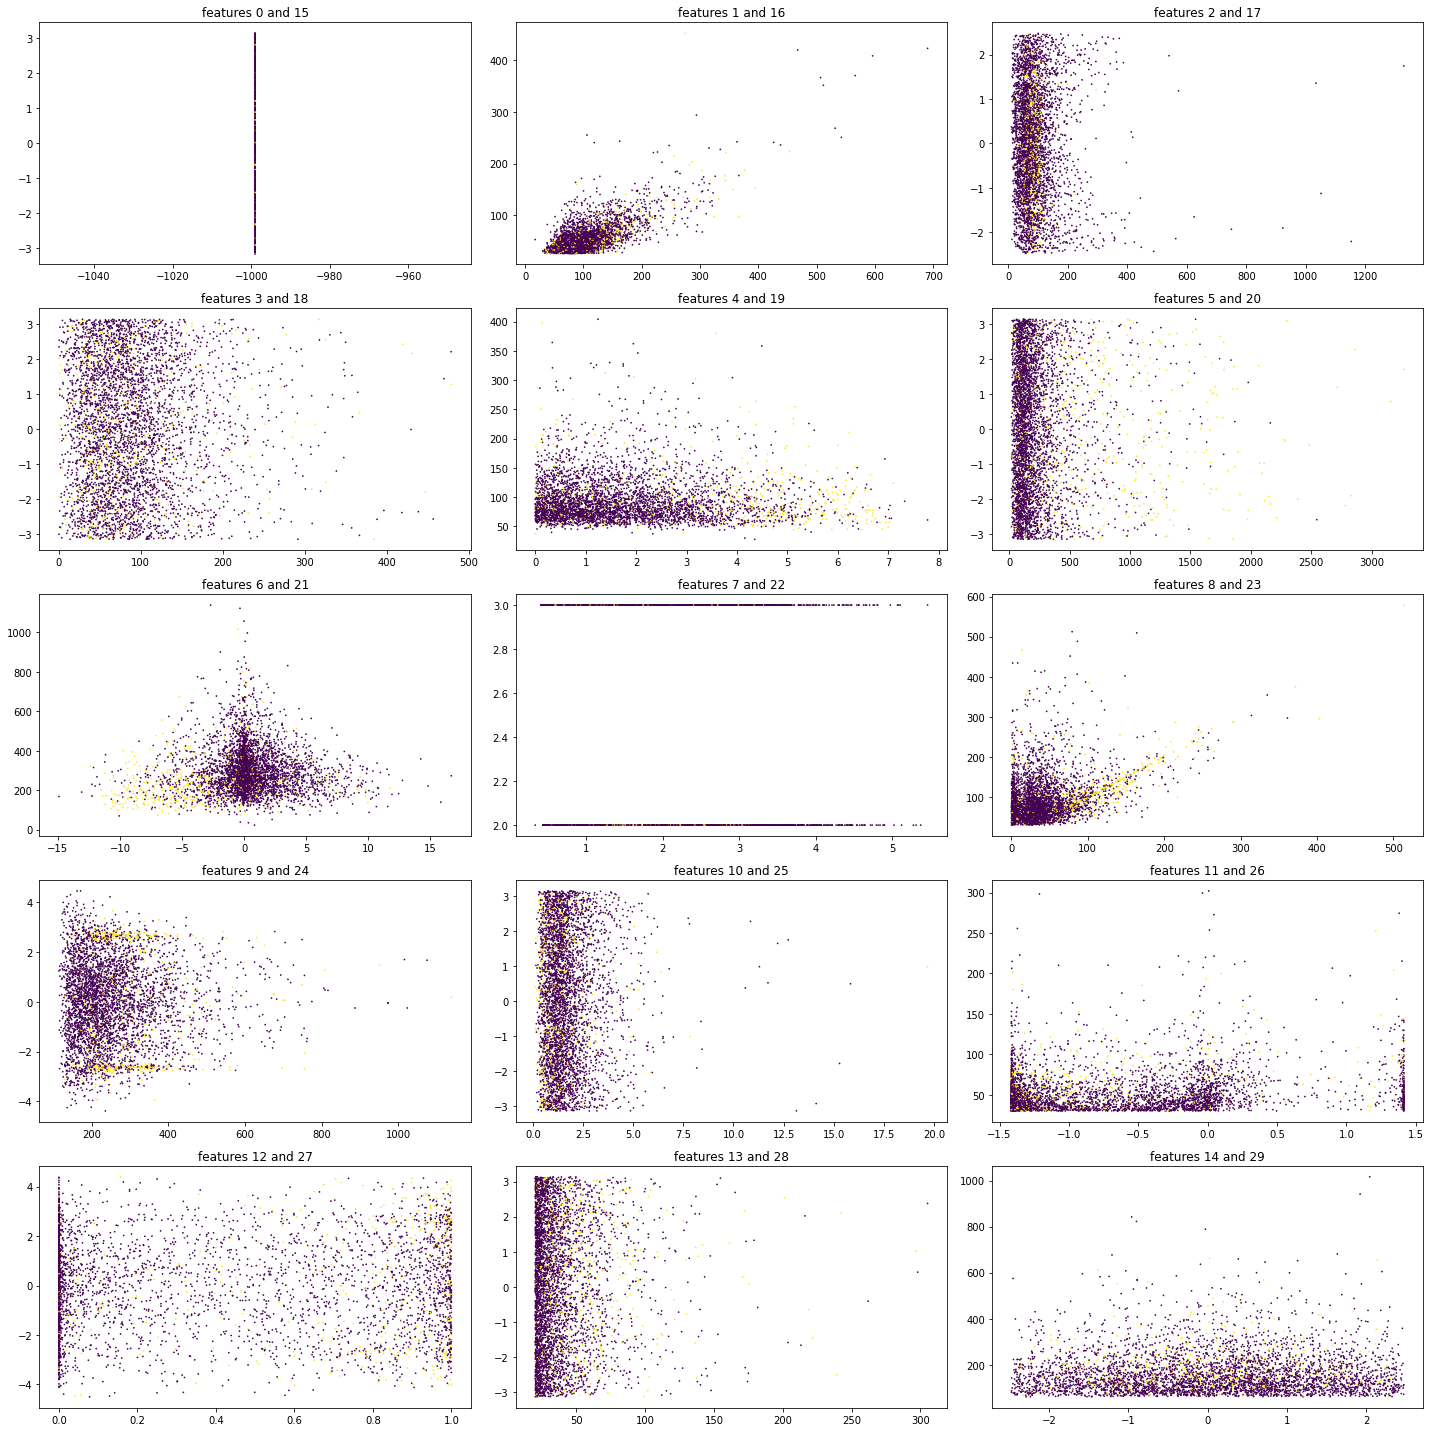

In [ ]:
X_2 = x_tr[(x_tr[:,0]==-999.)&(x_tr[:,4]!=-999.)]
Y_2 = y_tr[(x_tr[:,0]==-999.)&(x_tr[:,4]!=-999.)]

plot_scatters(X_2, Y_2)

### *Subset 3*

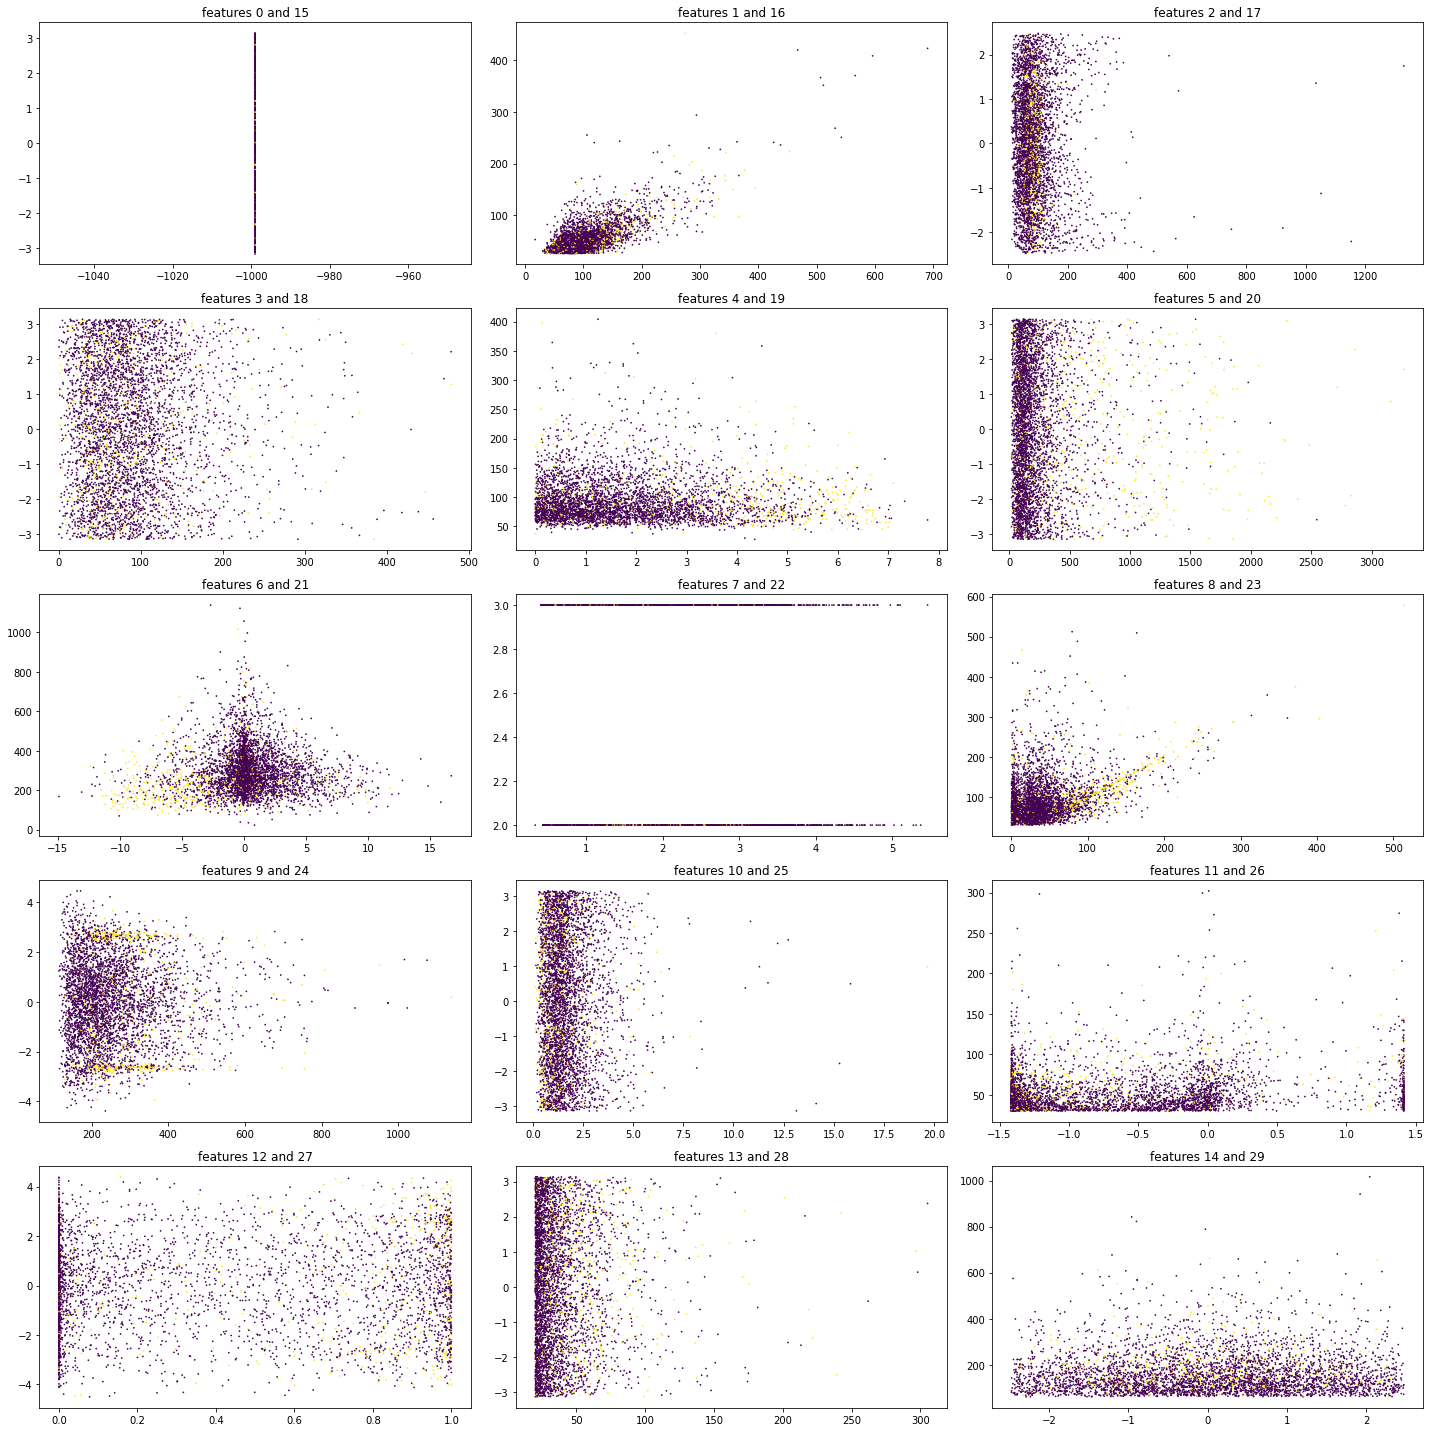

In [ ]:
X_3 = x_tr[(x_tr[:,0]==-999.)&(x_tr[:,4]!=-999.)&(x_tr[:,23]!=-999.)]
Y_3 = y_tr[(x_tr[:,0]==-999.)&(x_tr[:,4]!=-999.)&(x_tr[:,23]!=-999.)]

plot_scatters(X_3, Y_3)

### *Subset 4*

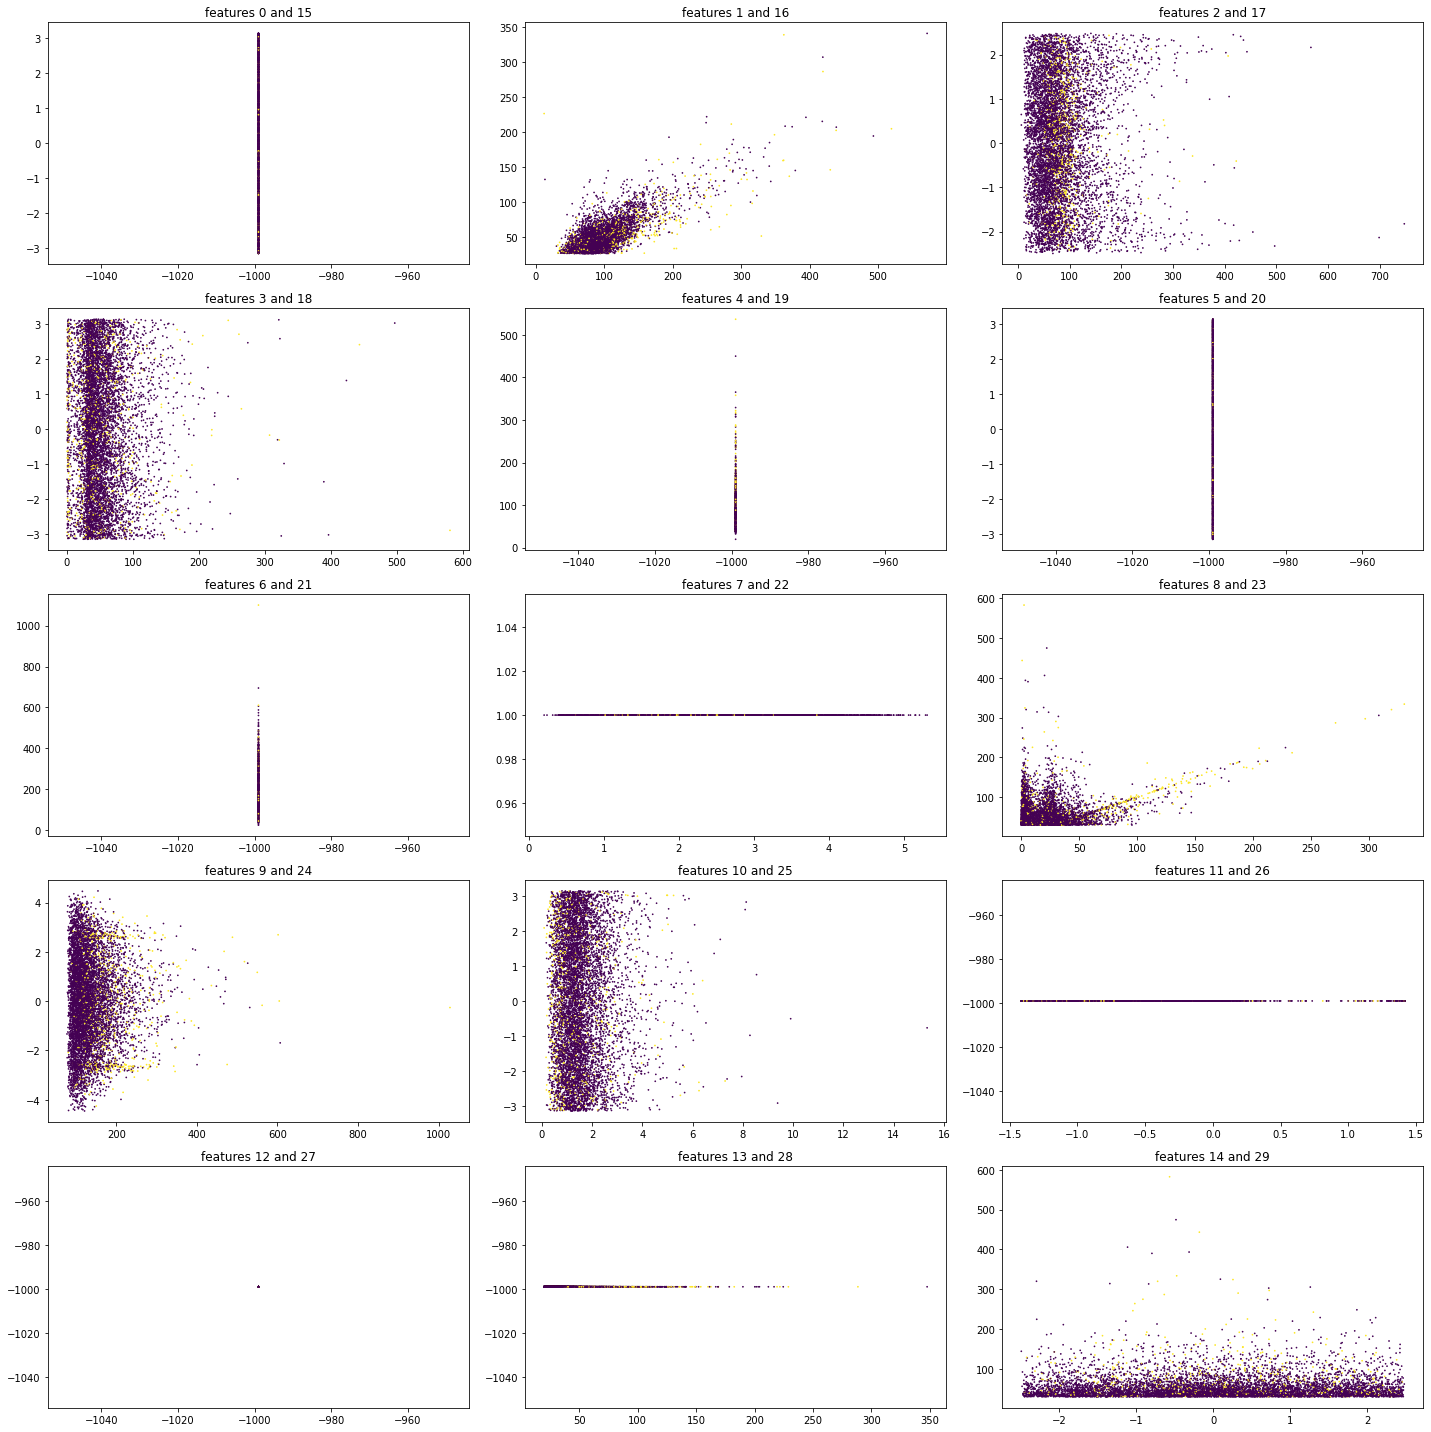

In [ ]:
X_4 = x_tr[(x_tr[:,0]==-999.)&(x_tr[:,4]==-999.)&(x_tr[:,23]!=-999.)]
Y_4 = y_tr[(x_tr[:,0]==-999.)&(x_tr[:,4]==-999.)&(x_tr[:,23]!=-999.)]

plot_scatters(X_4, Y_4)

### *Subset 5*

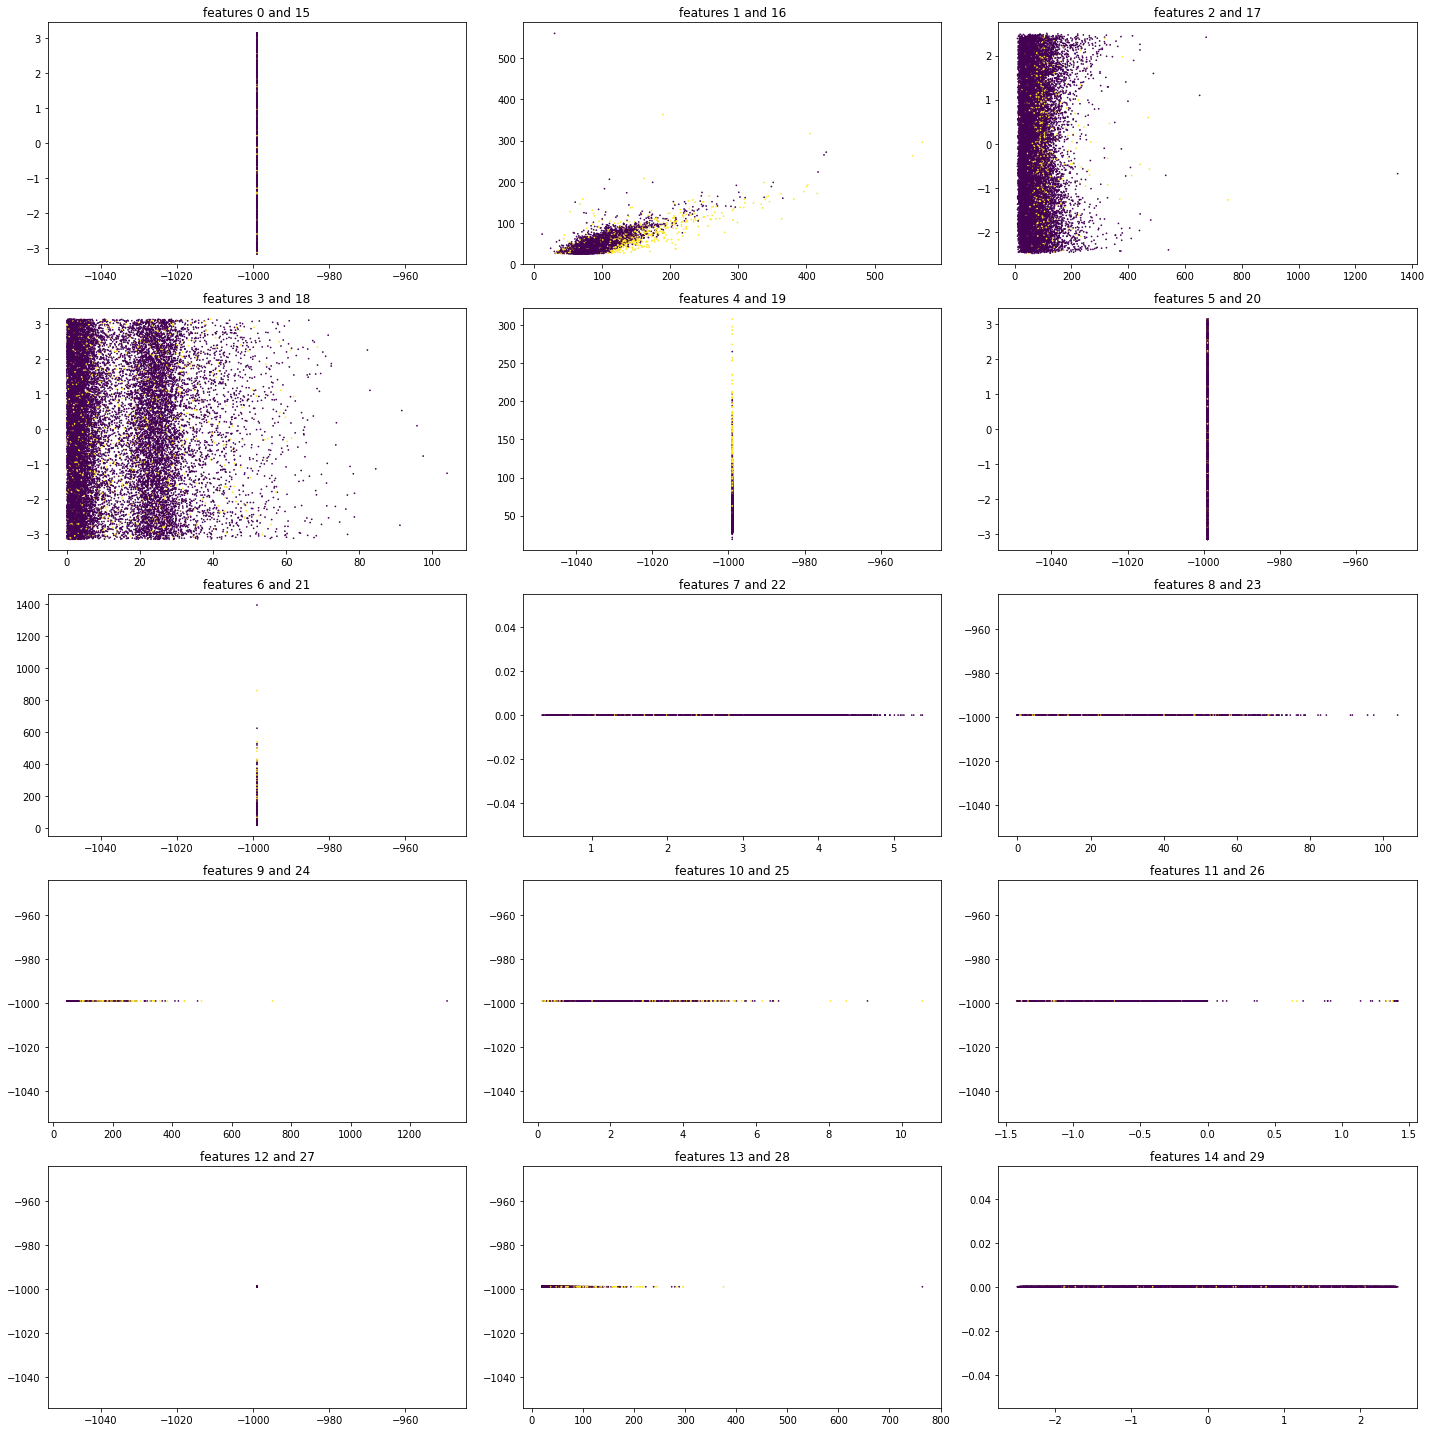

In [ ]:
X_5 = x_tr[(x_tr[:,0]==-999.)&(x_tr[:,4]==-999.)&(x_tr[:,23]==-999.)]
Y_5 = y_tr[(x_tr[:,0]==-999.)&(x_tr[:,4]==-999.)&(x_tr[:,23]==-999.)]

plot_scatters(X_5, Y_5)

As we can see in these scatter plots, we divided this train data into 5 independent subsets, all without a single feature mixing -999 and non -999 value. 
We have to separate our data again into other subsets. Feature 22 that only takes discrete values, for which our classifiers aren't adapted, has to be separated also into 4 subsets, for each possible value. At the end, we have 5 subsets(separation on -999 values) times 4 subsets (discrete feature 22) which gives us **20 subsets**, and so 20 classifiers to train, for each case.

### **3. Data pre-processing**

Now that data is adapted for linear classification, we can make several treatment of the train data in order to :
- make training faster
- improve models accuracy

#### **3.1 Removing unesuful features**

For each subset, we have unesuful features, i.e., the ones that only takes -999 values. We have to remove them. for this we have created a function : remove_non_useful_data(). Let's see it : 

In [ ]:
x_removed = remove_unique(x_tr[x_tr[:,0]!=-999.])
print(x_tr[x_tr[:,0]!=-999.])
print(x_removed)

[[ 1.38470e+02  5.16550e+01  9.78270e+01 ...  1.24000e+00 -2.47500e+00
   1.13497e+02]
 [ 1.60937e+02  6.87680e+01  1.03235e+02 ... -9.99000e+02 -9.99000e+02
   4.62260e+01]
 [ 1.43905e+02  8.14170e+01  8.09430e+01 ... -9.99000e+02 -9.99000e+02
   0.00000e+00]
 ...
 [ 2.17020e+02  4.71560e+01  6.28240e+01 ... -5.80000e-02 -1.13700e+00
   1.74176e+02]
 [ 1.05457e+02  6.05260e+01  7.58390e+01 ... -9.99000e+02 -9.99000e+02
   4.19920e+01]
 [ 9.49510e+01  1.93620e+01  6.88120e+01 ... -9.99000e+02 -9.99000e+02
   0.00000e+00]]
[[ 1.38470e+02  5.16550e+01  9.78270e+01 ...  1.24000e+00 -2.47500e+00
   1.13497e+02]
 [ 1.60937e+02  6.87680e+01  1.03235e+02 ... -9.99000e+02 -9.99000e+02
   4.62260e+01]
 [ 1.43905e+02  8.14170e+01  8.09430e+01 ... -9.99000e+02 -9.99000e+02
   0.00000e+00]
 ...
 [ 2.17020e+02  4.71560e+01  6.28240e+01 ... -5.80000e-02 -1.13700e+00
   1.74176e+02]
 [ 1.05457e+02  6.05260e+01  7.58390e+01 ... -9.99000e+02 -9.99000e+02
   4.19920e+01]
 [ 9.49510e+01  1.93620e+01  6.8

N.B : the unuseful features to remove depend on the subset, we have to use this fuction after separation of the train data.

#### **3.2 Standardize data**

It is very important to standardize data when using linear models. This is useful to have the same order of magnitude for all features. We use for this the function standardize(). We have to use this function after the data is divided into subsets. If not, the data will standadize using -999 values, hence making a unuseful standardization.

In [ ]:
x_standardized = standardize(x_tr_clean)
print(x_tr_clean)
print(x_standardized)

[[ 1.38470e+02  5.16550e+01  9.78270e+01 ...  1.24000e+00 -2.47500e+00
   1.13497e+02]
 [ 8.97440e+01  1.35500e+01  5.91490e+01 ...  2.24000e-01  3.10600e+00
   1.93660e+02]
 [ 1.48754e+02  2.88620e+01  1.07782e+02 ...  1.31000e-01 -2.76700e+00
   1.79877e+02]
 ...
 [ 1.26151e+02  2.90230e+01  9.52580e+01 ... -5.99000e-01 -2.52500e+00
   1.93099e+02]
 [ 1.30075e+02  3.91800e+00  6.67810e+01 ...  5.78000e-01 -2.21500e+00
   5.46066e+02]
 [ 2.17020e+02  4.71560e+01  6.28240e+01 ... -5.80000e-02 -1.13700e+00
   1.74176e+02]]
[[ 0.25767126  0.53283515  0.47461094 ...  0.61296467 -1.35932881
  -0.64515168]
 [-0.54438812 -0.70635039 -0.47504382 ...  0.11591226  1.71182322
   0.09496062]
 [ 0.4269521  -0.20839975  0.71903446 ...  0.07041435 -1.52001263
  -0.0322922 ]
 ...
 [ 0.05489308 -0.20316399  0.41153469 ... -0.28671976 -1.38684316
   0.08978114]
 [ 0.11948449 -1.01958579 -0.28765655 ...  0.28909784 -1.21625418
   3.34858158]
 [ 1.55065168  0.38652638 -0.38481214 ... -0.02204914 -0.62304

#### **3.3 Replacing -999 values by the mean of the feature**

At the beginning of our trials, we decided to replace the -999 value by the mean of the non -999 values of the feature, the function treat_data() do so. 

In [ ]:
x_treated = treat_data(x_tr)
print(x_tr)
print(x_treated)

[[ 138.47    51.655   97.827 ...    1.24    -2.475  113.497]
 [ 160.937   68.768  103.235 ... -999.    -999.      46.226]
 [-999.     162.172  125.953 ... -999.    -999.      44.251]
 ...
 [ 105.457   60.526   75.839 ... -999.    -999.      41.992]
 [  94.951   19.362   68.812 ... -999.    -999.       0.   ]
 [-999.      72.756   70.831 ... -999.    -999.       0.   ]]
[[ 1.38470000e+02  5.16550000e+01  9.78270000e+01 ...  1.24000000e+00
  -2.47500000e+00  1.13497000e+02]
 [ 1.60937000e+02  6.87680000e+01  1.03235000e+02 ... -1.18452642e-02
  -1.58228913e-03  4.62260000e+01]
 [ 1.21858528e+02  1.62172000e+02  1.25953000e+02 ... -1.18452642e-02
  -1.58228913e-03  4.42510000e+01]
 ...
 [ 1.05457000e+02  6.05260000e+01  7.58390000e+01 ... -1.18452642e-02
  -1.58228913e-03  4.19920000e+01]
 [ 9.49510000e+01  1.93620000e+01  6.88120000e+01 ... -1.18452642e-02
  -1.58228913e-03  0.00000000e+00]
 [ 1.21858528e+02  7.27560000e+01  7.08310000e+01 ... -1.18452642e-02
  -1.58228913e-03  0.0000000

#### **3.4 Replace right skewed features by their logarithm**

Linear models are very sensitive to ouliers. We thougth that replacing right skewed features by their logarithm would but in practice it didn't made any difference here is the function that does that : log_right_skewed(). 

N.B it will only log features that are right skewed, like this : 

x = log(x + 1 - xmin), xmin the minimum value taken by the feature concerned in order to only get positive outputs

In [ ]:
x_log = log_right_skewed(x_tr)
print(x_tr)
print(x_log)

[[ 138.47    51.655   97.827 ...    1.24    -2.475  113.497]
 [ 160.937   68.768  103.235 ... -999.    -999.      46.226]
 [-999.     162.172  125.953 ... -999.    -999.      44.251]
 ...
 [ 105.457   60.526   75.839 ... -999.    -999.      41.992]
 [  94.951   19.362   68.812 ... -999.    -999.       0.   ]
 [-999.      72.756   70.831 ... -999.    -999.       0.   ]]
[[ 138.47    51.655   97.827 ...    1.24    -2.475  113.497]
 [ 160.937   68.768  103.235 ... -999.    -999.      46.226]
 [-999.     162.172  125.953 ... -999.    -999.      44.251]
 ...
 [ 105.457   60.526   75.839 ... -999.    -999.      41.992]
 [  94.951   19.362   68.812 ... -999.    -999.       0.   ]
 [-999.      72.756   70.831 ... -999.    -999.       0.   ]]


#### **3.5 Make polynomial expansions**

We also tougth that a polynomial expansion could lead us to fit some unlinear realations between features and the output. Here is the fuction : polynomial_exp()

In [ ]:
x_poly = polynomial_exp(x_tr, 2)
print(x_tr.shape)
print(x_poly.shape)

(250000, 30)
(250000, 60)


#### **3.6 Remove correlated features**

Some of the features are very correlated

In [ ]:
corr = np.corrcoef(x_tr[:250000].T)
sns.heatmap(corr)

<AxesSubplot:>

In consequence, we thougth that making a PCA preprocessing could be a good idea, especially when the train for a model is very long. It is not usefull for all our models. 

# Least square

In [ ]:
y_tr, tx_tr = build_model_data(y_tr,x_tr)

In [ ]:
train_tx, train_y, val_tx, val_y = split_data(tx_tr,y_tr, 0.5, seed=2)

In [ ]:
print('\t Least squares')
start_time = datetime.datetime.now()
w, loss= least_squares(train_y, train_tx)
end_time = datetime.datetime.now()
# Print runtime
execution_time = (end_time - start_time).total_seconds()
print('Execution time={t:.3f} seconds'.format(t=execution_time))
print('Loss', loss)
ypred = np.sign(val_tx@w)
acc = accuracy(val_y, ypred)

print('Accuracy', acc)

	 Least squares
Execution time=0.045 seconds
Loss 0.33969568769637143
Accuracy 0.746048


/Users/Ccmac/Downloads/ML_Last/last_impl.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w,_,_,_ = np.linalg.lstsq(left,right)


# Mean square error gradient descent 

In [ ]:
print('\t Mean Square Gradient Descent')
start_time = datetime.datetime.now()
w, loss = mean_squared_error_gd(train_y, train_tx, initial_w=np.ones(train_tx.shape[1]), max_iters=10, gamma=0.01)
end_time = datetime.datetime.now()
# Print runtime
execution_time = (end_time - start_time).total_seconds()
print('Execution time={t:.3f} seconds'.format(t=execution_time))
print('Loss', loss)
ypred = np.sign(val_tx@w)
acc = accuracy(val_y, ypred)
print('Accuracy', acc)

	 Mean Square Gradient Descent
GD iter. 0/9: loss=25274212.983717293, w0=106.03315490992003, w1=-16584.2217993772
GD iter. 1/9: loss=3.242011447504622e+17, w0=-13139841.410127835, w1=1453374725.6106544
GD iter. 2/9: loss=4.2655964181239546e+27, w0=1511803083242.205, w1=-164089660911553.97
GD iter. 3/9: loss=5.612889439256278e+37, w0=-1.7344747382835043e+17, w1=1.8803383455507304e+19
GD iter. 4/9: loss=7.385731098626076e+47, w0=1.9896484115199983e+22, w1=-2.1567782888377707e+24
GD iter. 5/9: loss=9.718528167564855e+57, w0=-2.2823394179113424e+27, w1=2.4740371934020596e+29
GD iter. 6/9: loss=1.2788143581963545e+68, w0=2.6180851451927408e+32, w1=-2.8379810598206048e+34
GD iter. 7/9: loss=1.6827302802779688e+78, w0=-3.0032208633905924e+37, w1=3.2554645892428775e+39
GD iter. 8/9: loss=2.2142238066188434e+88, w0=3.4450122900686924e+42, w1=-3.734362532640862e+44
GD iter. 9/9: loss=2.913590563656944e+98, w0=-3.951793828242222e+47, w1=4.283709189013995e+49
Execution time=0.077 seconds
Loss 2.91

# Mean square error stochastic gradient descent 

In [ ]:
print('\t Mean Square Stochastic Gradient Descent')
start_time = datetime.datetime.now()
w, loss = mean_squared_error_sgd(train_y, train_tx, initial_w=np.ones(train_tx.shape[1]), max_iters=10, gamma=0.01)
end_time = datetime.datetime.now()
# Print runtime
execution_time = (end_time - start_time).total_seconds()
print('Execution time={t:.3f} seconds'.format(t=execution_time))
print('Loss', loss)
ypred = np.sign(val_tx@w)
acc = accuracy(val_y, ypred)
print('Accuracy', acc)

	 Mean Square Stochastic Gradient Descent
SGD iter. 0/9: loss=18959638.363384496, w0=124.15726, w1=17692.29408448
SGD iter. 1/9: loss=3.729108766175812e+17, w0=-17272070.297819093, w1=-1633292831.9615598
SGD iter. 2/9: loss=1.7801316118900922e+25, w0=-119353154750.742, w1=-81510189209463.6
SGD iter. 3/9: loss=7.320717975715516e+32, w0=-765401940214747.4, w1=-9.47056409488298e+16
SGD iter. 4/9: loss=3.665319203970551e+39, w0=-1.71314835069217e+18, w1=-2.797199916403481e+20
SGD iter. 5/9: loss=6.0659307209960856e+44, w0=-6.983295834709718e+20, w1=-1.0782475847837935e+23
SGD iter. 6/9: loss=1.1984086113452922e+55, w0=9.791390165817288e+25, w1=1.00605194093835e+28
SGD iter. 7/9: loss=2.3322119786429027e+65, w0=-1.3659219722475065e+31, w1=-1.357248036419164e+33
SGD iter. 8/9: loss=4.753567031644198e+75, w0=1.9500770118300516e+36, w1=1.1739215105848892e+38
SGD iter. 9/9: loss=9.82483414995457e+81, w0=-2.801595413962707e+39, w1=-9.12585660362746e+40
Execution time=0.006 seconds
Loss 9.8248341

# Ridge regression 

In [ ]:
print('\t Ridge regression')
start_time = datetime.datetime.now()
w, loss = ridge_regression(y_tr, tx_tr, lambda_=0.01)
end_time = datetime.datetime.now()
# Print runtime
execution_time = (end_time - start_time).total_seconds()
print('Execution time={t:.3f} seconds'.format(t=execution_time))
print('Loss', loss)
ypred = np.sign(val_tx@w)
acc = accuracy(val_y, ypred)
print('Accuracy', acc)

	 Ridge regression
Execution time=0.068 seconds
Loss 0.33991734228671966
Accuracy 0.7441040000000001


/Users/Ccmac/Downloads/ML_Last/last_impl.py:147: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w,_,_,_ = np.linalg.lstsq(left,right)


# Logistic regression

In [ ]:

K_fold_pipeline_log(tx_tr,np.reshape(y_tr, (len(y_tr),1)), 100, 0.1 ,0.1, 100, 0.05)

/Users/Ccmac/Downloads/ML_Last/last_impl.py:166: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


----- Regression logistique ----- 
k:  100
lambda_ridge:  0.1
lambda_lasso:  0.1
max_iters:  100
gamma:  0.05
Accuracy 0.5483160000000001 



# SVM

In [ ]:
K_fold_pipeline_SVM(tx_tr,np.reshape(y_tr, (len(y_tr),1)), 2, 0.1 ,0, 100, 0.01)

----- Soft Vector Machine ----- 
k:  2
lambda_ridge:  0.1
lambda_lasso:  0
max_iters:  100
gamma:  0.01
Accuracy 0.6609160000000001 

